In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# Third party import
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
import scipy.io
from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
from modopt.opt.proximity import SparseThreshold
from mri.numerics.fourier import FFT2, NFFT
from mri.numerics.gradient import GradAnalysis2
from mri.numerics.linear import WaveletUD
from mri.numerics.reconstruct import sparse_rec_condatvu
from mri.numerics.utils import convert_mask_to_locations
import pysap
from pysap.data import get_sample_data


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.2.1     installed
numpy          : >=1.11.0  - required | 1.16.2    installed
matplotlib     : >=2.0.0   - required | 3.0.3     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
pywt           : >=1.0.0   - required | 1.0.2     installed
mri            : ==0.0.0   - requi

#  Loading input data

In [2]:
image = get_sample_data("mri-slice-nifti")
original_image_data = np.copy(image.data)
image.data += np.random.randn(*image.shape) * 20.
image.data = image.data.astype(np.complex128)
mask = get_sample_data("mri-mask")

In [3]:
non_cartesian = True
sparkling = True
opt_results = {}

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [4]:
# potential path to sparkling trajectory
sparkling_traj_file_path = '../personal_experiments/2019-Mar-01_N512_nc34_ns3073_OS1_decim64_decay2_tau0.75_nrevol1/samples_SPARKLING_N512_nc34x3073_OS1.mat'

In [5]:
# Generate the subsampled kspace
if non_cartesian:
    if sparkling:
        kspace_loc = scipy.io.loadmat(sparkling_traj_file_path)['samples']
    else:
        kspace_loc = convert_mask_to_locations(mask.data)
    fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)
else:
    kspace_mask = np.fft.ifftshift(mask.data)
    kspace_loc = convert_mask_to_locations(kspace_mask)
    fourier_op = FFT2(
        samples=kspace_loc,
        shape=data.shape)
    kspace_data = fourier_op.op(image.data)
    
    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)

/home/zaccharie/workspace/pysap-mri/mri/reconstruct/fourier.py:172: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/zaccharie/workspace/pysap-mri/mri/reconstruct/utils.py:103: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


# Operators

In [6]:
nb_scales = 4
wavelet_id = 24

In [7]:
linear_op = WaveletUD(
    nb_scale=nb_scales,
    wavelet_id=wavelet_id,
    set_norm=1.1,
)

gradient_op = GradAnalysis2(
    data=kspace_data,
    fourier_op=fourier_op)

# Define the proximity dual/primal operator
prox_op = SparseThreshold(linear_op, None, thresh_type="soft")
cost_op = None

# Condat optimization
We now want to refine the zero order solution using a Condat optimization.

In [8]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_data)**2

In [9]:
def nrmse(x):
    return np.linalg.norm(x - original_image_data) / np.mean(original_image_data)

In [10]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [11]:
mu = 80

In [17]:
max_iter = 300
convergence_pot = max_iter >= 500

In [18]:
# Start the Condat reconstruction
cost_op = None
x_final, transform, costs, metrics = sparse_rec_condatvu(
    gradient_op,
    linear_op,
    prox_op,
    cost_op,
    std_est_method='dual',
    std_est=0.1,
    mu=mu,
    sigma=10,
    nb_of_reweights=0,
    max_nb_of_iter=max_iter,
    metrics=metrics_,
    metric_call_period=20,
    verbose=1,
)
image_rec = pysap.Image(data=np.abs(x_final))


   ____   U  ___ u  _   _    ____       _       _____      __     __    _   _
U /"___|   \/"_ \/ | \ |"|  |  _"\  U  /"\  u  |_ " _|     \ \   /"/uU |"|u| |
\| | u     | | | |<|  \| |>/| | | |  \/ _ \/     | |        \ \ / //  \| |\| |
 | |/__.-,_| |_| |U| |\  |uU| |_| |\ / ___ \    /| |\       /\ V /_,-. | |_| |
  \____|\_)-\___/  |_| \_|  |____/ u/_/   \_\  u |_|U      U  \_/-(_/ <<\___/
 _// \\      \\    ||   \\,-.|||_    \\    >>  _// \\_       //      (__) )(
(__)(__)    (__)   (_")  (_/(__)_)  (__)  (__)(__) (__)     (__)         (__)
    
 - mu:  80
 - lipschitz constant:  95.51082265332474
 - tau:  0.01670692720454975
 - sigma:  10
 - rho:  1.0
 - std:  0.1
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.reconstruct.linear.WaveletUD object at 0x7f551cc91160> - 4
 - max iterations:  300
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (10, 512, 512)
----------------------------------------
Starting optimi

100% (300 of 300) |######################| Elapsed Time: 0:16:09 Time:  0:16:09


 - converged:  False
Done.
Execution time:  1425.4846009999999  seconds
----------------------------------------


[autoreload of modopt.opt.proximity failed: Traceback (most recent call last):
  File "/home/zaccharie/workspace/pysap-mri/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/zaccharie/workspace/pysap-mri/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/zaccharie/workspace/pysap-mri/venv/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/zaccharie/workspace/pysap-mri/venv/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/zaccharie/workspace/ModOpt/modopt/opt/proximity.py", line 24, in <module>
    from m

<IPython.core.display.Javascript object>


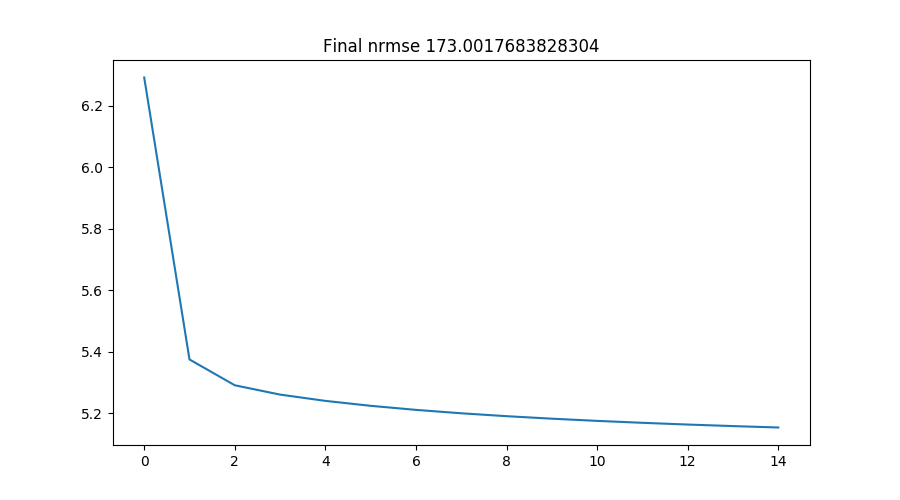

Text(0.5, 1.0, 'Final nrmse 173.0017683828304')

In [19]:
plt.figure(figsize=(9, 5))
plt.plot(np.log(np.array(metrics['nrmse']['values'])))
plt.title('Final nrmse {}'.format(metrics['nrmse']['values'][-1]))